# Vehicle Detection: Scale and frame refinement #
Using SVM Classifier

In [25]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from scipy.ndimage.measurements import label
import time

%matplotlib inline

In [31]:
### Code taken from Udacity's lessons on SDC nanodegree

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2')
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def find_cars(img, ystart, ystop, scale, svc, X_scaler, pca, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, threshold=2, color_space='BGR2HLS'):
    
    draw_img = np.copy(img)
  #  img = img.astype(np.float32)/255

    bbox_list = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_features = pca.transform(test_features)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    #            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    #draw_img = combine_bbox(draw_img, bbox_list, threshold)
    
    #return draw_img
    return bbox_list

def combine_bbox(img, bbox_list, threshold):
    heatmap = add_heat(np.zeros_like(img), bbox_list)
    heatmap = apply_threshold(heatmap, threshold)
    labels = label(heatmap)
    bboxes = get_labeled_bboxes(img, labels)
        
    return bboxes
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold=2):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(img, labels):
    bbox = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    # Return the image
    return bbox

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [30]:
### Initialize feature extraction parameters and import classifer & scaler
color_space='HLS'
spatial_size=(32, 32)
hist_bins=16
orient=9
pix_per_cell=6
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True

with open('svc_pca_scaler.p', 'rb') as f:
    svc_scaler = pickle.load(f)
clf_svc = svc_scaler['clf_svc_pca']
X_scaler = svc_scaler['scaler']
pca = svc_scaler['pca']

In [5]:
img = cv2.imread('test_images/img3.jpg')

In [24]:
### get test image & test
import time

t0 = time.time()
bbox1 = find_cars(img, ystart=350, ystop=700, scale=4, svc=clf_svc, X_scaler=X_scaler, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

bbox2 = find_cars(img, ystart=415, ystop=470, scale=0.5, svc=clf_svc, X_scaler=X_scaler, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

bbox3 = find_cars(img, ystart=400, ystop=550, scale=2, svc=clf_svc, X_scaler=X_scaler, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

bbox1.extend(bbox2)
bbox1.extend(bbox3)
draw_img = combine_bbox(np.copy(img), bbox1, 1)
plt.imshow(draw_img[:,:,::-1])
print(time.time()-t0)

TypeError: find_cars() missing 1 required positional argument: 'pca'

In [86]:
with open('rf_scaler.p', 'rb') as f:
    rf_scaler = pickle.load(f)
clf_rf = rf_scaler['clf_rf']

5.36577296257019


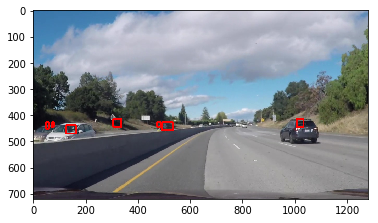

In [193]:
t0 = time.time()
bbox1 = find_cars(img, ystart=350, ystop=700, scale=4, svc=clf_rf, X_scaler=X_scaler, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

bbox2 = find_cars(img, ystart=415, ystop=470, scale=0.5, svc=clf_rf, X_scaler=X_scaler, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

bbox3 = find_cars(img, ystart=400, ystop=550, scale=1, svc=clf_rf, X_scaler=X_scaler, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

bbox1.extend(bbox2)
bbox1.extend(bbox3)
draw_img = combine_bbox(np.copy(img), bbox1, 1)
plt.imshow(draw_img[:,:,::-1])
print(time.time()-t0)

In [88]:
with open('ada_scaler.p', 'rb') as f:
    ada_scaler = pickle.load(f)
clf_ada = ada_scaler['clf_ada']

0.3128070831298828


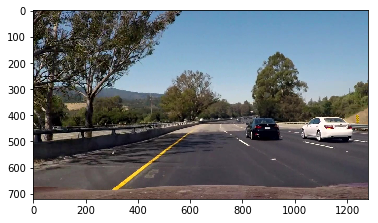

In [125]:
t0 = time.time()
draw_img = find_cars(img, ystart=400, ystop=600, scale=3, svc=clf_ada, X_scaler=X_scaler, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

plt.imshow(draw_img[:,:,::-1])
print(time.time()-t0)

In [7]:
with open('svc_pca_scaler.p', 'rb') as f:
    svc_dict = pickle.load(f)
clf_svc_pca = svc_dict['clf_svc_pca']
X_scaler = svc_dict['scaler']
pca = svc_dict['pca']

1.5827243328094482


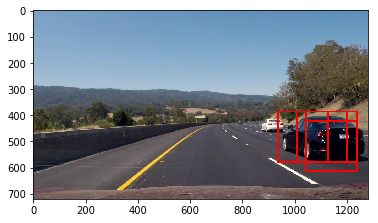

In [48]:
img = cv2.imread('test_images/img1.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=350, ystop=700, scale=3, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

#draw_img = combine_bbox(np.copy(img), bbox1, 0)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

2.4762184619903564


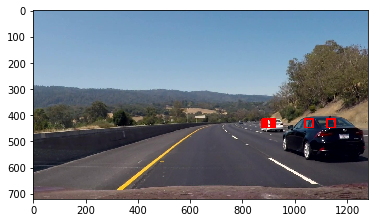

In [59]:
img = cv2.imread('test_images/img1.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=415, ystop=450, scale=0.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

#draw_img = combine_bbox(np.copy(img), bbox1, 0)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

1.5225236415863037


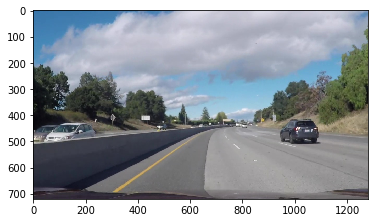

In [50]:
img = cv2.imread('test_images/img2.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=350, ystop=700, scale=3, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

#draw_img = combine_bbox(np.copy(img), bbox1, 0)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

2.8384292125701904


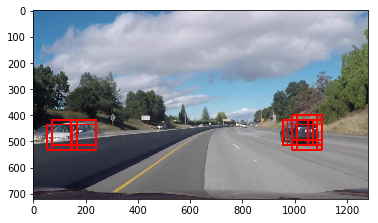

In [60]:
img = cv2.imread('test_images/img2.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=400, ystop=550, scale=1.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

#draw_img = combine_bbox(np.copy(img), bbox1, 0)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

4.663278579711914


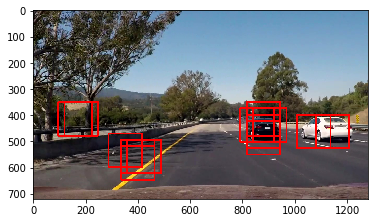

In [52]:
img = cv2.imread('test_images/img3.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=350, ystop=700, scale=2, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

#draw_img = combine_bbox(np.copy(img), bbox1, 0)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

2.585371494293213


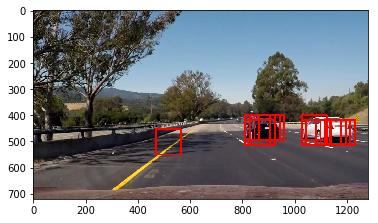

In [53]:
img = cv2.imread('test_images/img3.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=400, ystop=550, scale=1.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins)

#draw_img = combine_bbox(np.copy(img), bbox1, 0)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

The above test yield 3 search frames and their corresponding scales, optimal for vehicle detection at various distances:

- ystart: 415 | ystop: 455 | scale: 0.5  -- Farthest
- ystart: 400 | ystop: 550 | scale: 1.5  -- Mid-range
- ystart: 350 | ystop: 700 | scale: 3.0  -- Closest

#### Heatmap and labelling ####

In [8]:
img = cv2.imread('test_images/img1.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=350, ystop=700, scale=3, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=0)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

TypeError: list indices must be integers or slices, not tuple

2.9238009452819824


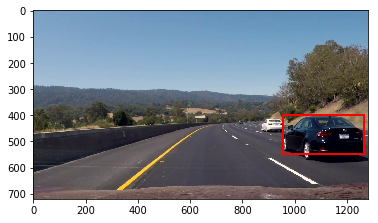

In [92]:
img = cv2.imread('test_images/img1.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=400, ystop=550, scale=1.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

4.499361515045166


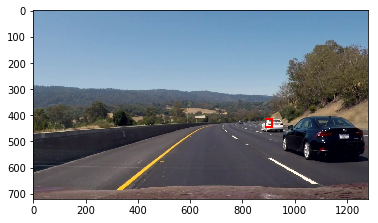

In [77]:
img = cv2.imread('test_images/img1.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=415, ystop=455, scale=0.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

1.7550365924835205


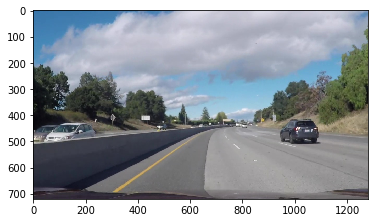

In [78]:
img = cv2.imread('test_images/img2.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=350, ystop=700, scale=3, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=0)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

3.0959649085998535


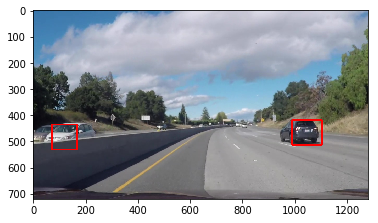

In [79]:
img = cv2.imread('test_images/img2.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=400, ystop=550, scale=1.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

4.490252256393433


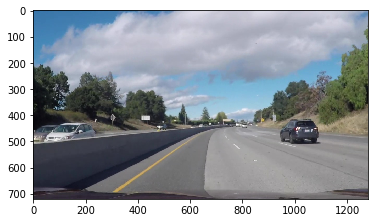

In [80]:
img = cv2.imread('test_images/img2.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=415, ystop=455, scale=0.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

1.737389087677002


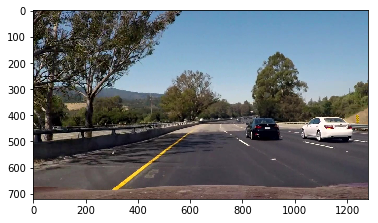

In [81]:
img = cv2.imread('test_images/img3.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=350, ystop=700, scale=3, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=0)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

2.9474196434020996


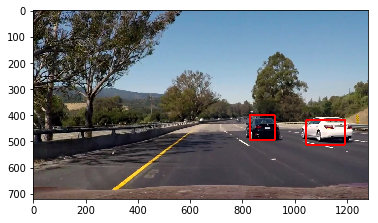

In [87]:
img = cv2.imread('test_images/img3.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=400, ystop=550, scale=1.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

4.826085567474365


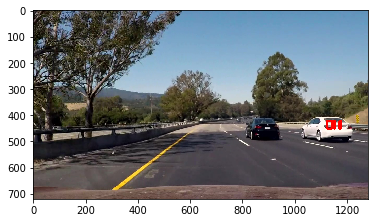

In [83]:
img = cv2.imread('test_images/img3.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=415, ystop=455, scale=0.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)

plt.imshow(bbox1[:,:,::-1])
print(time.time()-t0)

** Cobmine boubding boxes from all 3 search frames: **

7.310375213623047


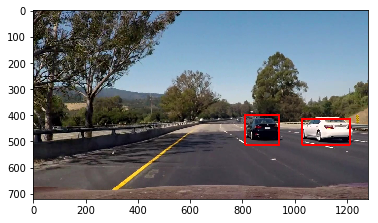

In [108]:
img = cv2.imread('test_images/img3.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=415, ystop=455, scale=0.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)

bbox2 = find_cars(img, ystart=400, ystop=550, scale=1.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)



bbox1.extend(bbox2)
#bbox1.extend(bbox3)

draw_img = combine_bbox(np.copy(img), bbox1, threshold=1)

plt.imshow(draw_img[:,:,::-1])
print(time.time()-t0)

8.392940044403076


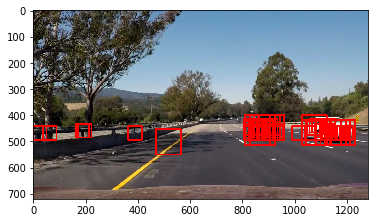

In [33]:
img = cv2.imread('test_images/img3.jpg')
t0 = time.time()
bbox1 = find_cars(img, ystart=415, ystop=500, scale=0.8, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)

bbox2 = find_cars(img, ystart=400, ystop=550, scale=1.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)


bbox1.extend(bbox2)
#bbox1.extend(bbox3)

#draw_img = combine_bbox(np.copy(img), bbox1, threshold=2)
draw_img = draw_boxes(img, bbox1)

plt.imshow(draw_img[:,:,::-1])
print(time.time()-t0)

6.786095142364502


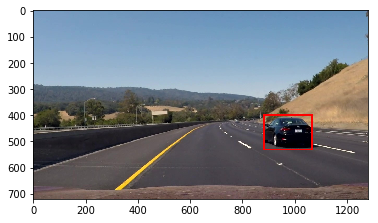

In [9]:
img = cv2.imread('test_images/img7.jpg')
t0 = time.time()
bbox3 = find_cars(img, ystart=415, ystop=455, scale=0.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)

bbox4 = find_cars(img, ystart=400, ystop=550, scale=1.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
hist_bins=hist_bins, threshold=2)


bbox1.extend(bbox2)
#bbox1.extend(bbox3)

draw_img = combine_bbox(np.copy(img), bbox1, threshold=2)

plt.imshow(draw_img[:,:,::-1])
print(time.time()-t0)

In [21]:
frame_box_list = []
n_frames=10

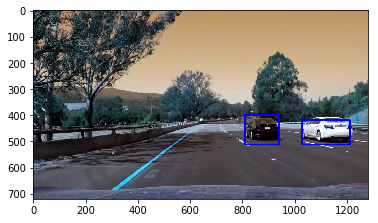

In [22]:
img = cv2.imread('test_images/img3.jpg')
bbox1 = find_cars(img, ystart=400, ystop=550, scale=1.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
                  hist_bins=hist_bins, threshold=2, color_space='BGR2HLS')

#bbox2 = find_cars(img, ystart=415, ystop=455, scale=0.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
 #                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
  #                hist_bins=hist_bins, threshold=2, color_space=color_space)
#bbox1.extend(bbox2)
bboxes = combine_bbox(img, bbox1, threshold=1)


if len(frame_box_list) >= n_frames:
    frame_box_list[:-1] = frame_box_list[1:]
    frame_box_list[-1] = bboxes
else:
    frame_box_list.append(bboxes)

bboxes.extend(frame_box_list[0])
combined_bbox = combine_bbox(img, bboxes, threshold=1)

draw_img = draw_boxes(img, combined_bbox)

plt.imshow(draw_img)

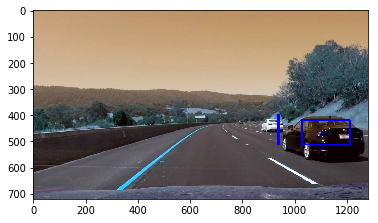

In [23]:
img = cv2.imread('test_images/img1.jpg')
bbox1 = find_cars(img, ystart=400, ystop=550, scale=1.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
                  hist_bins=hist_bins, threshold=2, color_space='BGR2HLS')

#bbox2 = find_cars(img, ystart=415, ystop=455, scale=0.5, svc=clf_svc_pca, X_scaler=X_scaler, pca=pca, orient=orient, 
 #                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
  #                hist_bins=hist_bins, threshold=2, color_space=color_space)
#bbox1.extend(bbox2)
bboxes = combine_bbox(img, bbox1, threshold=1)


if len(frame_box_list) >= n_frames:
    frame_box_list[:-1] = frame_box_list[1:]
    frame_box_list[-1] = bboxes
else:
    frame_box_list.append(bboxes)

bboxes.extend(frame_box_list[0])
combined_bbox = combine_bbox(img, bboxes, threshold=2)

draw_img = draw_boxes(img, combined_bbox)

plt.imshow(draw_img)